<center>

*******************************************************************************************
    
### Pre-processing of AlphaPose Output

##### 30 January 2025

##### Juan Ignacio Mendoza Garay  

*******************************************************************************************

</center>

##### INFORMATION:

* Extract one point of the body (in this demonstration the nose) tracked by AlphaPose, for every tracked person in the picture. Then, get rid of extraneous data, interpolate missing data, and rearrange the tabular data. The resulting table has columns {p1_x,p1_y,p2_x,p2_y,...} where p is a tracked person from left to right, and {x,y} are horizontal and vertical coordinates of the point.
* AlphaPose output may be obtained using the file "Pose_Detection_Tracking_Youtube_DEMO.ipynb", \
    here:  https://github.com/juigmend/python-miscellaneous/blob/main/Pose_Detection_Tracking_Youtube_DEMO.ipynb
>
* Instructions:

    Edit the values indicated with an arrow like this: <---  
    Comment/uncomment or change values as suggested by the comments.  
    Run the program, close your eyes and hope for the best.  

*******************************************************************************************

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

***
#### Set paths and parameters:

In [20]:
AP_results_path = r"C:\Users\Raul_Menendez\Documents\AlphaPose_results" # <--- folder where AlphaPose results are
AP_results_fn = "alphapose-results.json" # <--- AlphaPose results (JSON file)

n_ppl = 4 # <--- number of individuals tracked
save_file = False # <--- save pre-processed data to a parquet file

***
#### Get AlphaPose output:

In [21]:
# Load data from JSON file produced by AlphaPose:

data_raw_df = pd.read_json(AP_results_path + '\\' + AP_results_fn)
data_raw_df.head(n_ppl*2)

,image_id,category_id,keypoints,score,box,idx
0,0.jpg,1,"[824.240966796875, 481.97174072265625, 0.94075...",2.937277,"[649.7055053710938, 375.6181335449219, 261.007...",1
1,0.jpg,1,"[1642.2366943359375, 526.0736083984375, 0.9327...",2.772717,"[1456.5623779296875, 429.5651550292969, 402.08...",2
2,0.jpg,1,"[1320.0240478515625, 456.77374267578125, 0.945...",2.913743,"[1158.9583740234375, 371.8351745605469, 261.93...",3
3,0.jpg,1,"[333.0621032714844, 503.0393371582031, 0.95009...",2.652272,"[142.22679138183594, 401.2928161621094, 271.49...",4
4,1.jpg,1,"[824.4315185546875, 481.26055908203125, 0.9387...",2.940219,"[649.6185573402222, 374.89906616210936, 261.36...",1
5,1.jpg,1,"[1643.3443603515625, 523.2674560546875, 0.8864...",2.687304,"[1458.633364533205, 432.8249694824219, 399.514...",2
6,1.jpg,1,"[1319.69677734375, 456.9287414550781, 0.940677...",2.914894,"[1158.792494631884, 372.01452026367184, 261.78...",3
7,1.jpg,1,"[332.97174072265625, 503.3334655761719, 0.9497...",2.650749,"[142.3871281001917, 401.6517028808593, 271.167...",4


In [22]:
# Reduce by removing unnecessary data:
#    Keep [x1,y1,confidence] for "Nose", assuming COCO format.

data_red_df = data_raw_df.drop(['category_id','keypoints','score','box'],axis=1)
data_red_df['x'] = data_raw_df.keypoints.str[0] 
data_red_df['y'] = data_raw_df.keypoints.str[1] 
data_red_df['conf'] = data_raw_df.keypoints.str[2]
data_red_df.image_id = data_red_df.image_id.str.split('.').str[0].astype(int)
data_red_df.head(n_ppl*2)

,image_id,idx,x,y,conf
0,0,1,824.240967,481.971741,0.940755
1,0,2,1642.236694,526.073608,0.932772
2,0,3,1320.024048,456.773743,0.945395
3,0,4,333.062103,503.039337,0.950098
4,1,1,824.431519,481.260559,0.938731
5,1,2,1643.344360,523.267456,0.886494
6,1,3,1319.696777,456.928741,0.940677
7,1,4,332.971741,503.333466,0.949702


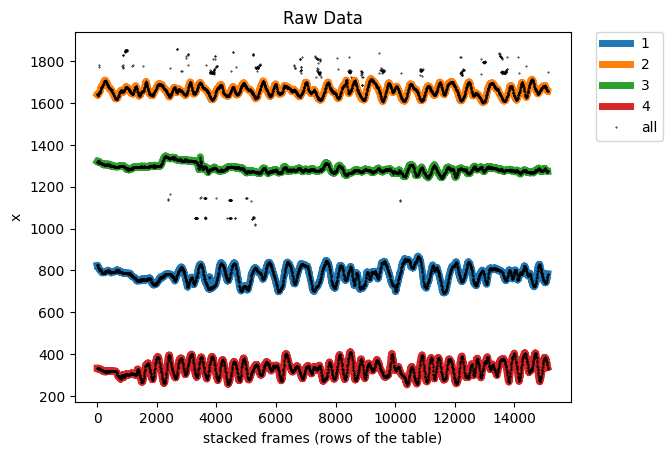

In [29]:
# Inspect raw data:

sel_axis = 'x' # <---

# fps = 29.97 # <---
# t_range = [0,fps*16] # <--- time range to display in frames (fps*seconds = frames)
t_range = [0,data_red_df.image_id.max()] # <--- time range to display in frames (fps*seconds = frames)

n_frames = []
legend = []
idx_range = range(1,n_ppl+1)
for i in idx_range:
    data_red_slice_df = data_red_df[sel_axis][  (data_red_df.idx == i) 
                                              & (data_red_df.image_id >= t_range[0]) 
                                              & (data_red_df.image_id < t_range[1])  ]
    data_red_slice_df.plot(linewidth=5)
    legend.append(i)
    n_frames.append(len(data_red_slice_df))
data_red_df[sel_axis].plot(marker = '.', linestyle='none', markersize = 0.8, color='k')
plt.legend(legend+['all'],loc='upper right', bbox_to_anchor=(1.2, 1.02))
plt.title('Raw Data')
plt.xlabel('stacked frames (rows of the table)')
plt.ylabel(sel_axis)

mean_ = sum(n_frames)/n_ppl
for p in n_frames:
    if p != mean_:
        print(f'Warning: missing frames')
        break

if (data_red_df.idx.max()) != n_ppl:
    print('Warning: more idx than number of people')

***
#### Pre-process data and save:

In [24]:
# Rearrange such that each row is a frame (image_id), and fill missing data:

data_rar_df = pd.DataFrame( list(range(data_red_df.image_id.max() + 1)) , columns=['image_id'])

for i in idx_range:
    data_rar_df = data_rar_df.merge( data_red_df[['image_id','x','y']][(data_red_df.idx == i)],
                                     on='image_id', how='left', suffixes=(f'_{i-1}',f'_{i}') )
data_rar_df = data_rar_df.drop(['image_id'],axis=1)
found_nan = data_rar_df.isnull().values.any()
if found_nan:
    data_rar_df = data_rar_df.interpolate(limit_direction='both')
    print('Warning: missing data have been interpolated')
data_rar_df.head()

,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4
0,824.240967,481.971741,1642.236694,526.073608,1320.024048,456.773743,333.062103,503.039337
1,824.431519,481.260559,1643.344360,523.267456,1319.696777,456.928741,332.971741,503.333466
2,825.146423,480.956451,1644.571167,522.328247,1319.345825,457.133484,332.376343,503.262421
3,824.775391,481.568176,1639.519775,519.385620,1320.066772,458.254700,332.940613,504.186920
4,824.599915,481.871490,1640.087646,518.384888,1320.838013,457.984589,333.052216,503.459595


In [25]:
# Re-order and re-label columns in order from left to right as they appear in the image:
# It is assumed that the persons don't relocate (e.g. they are sitting or standing in one place).
# Indices are set to start at 0 to be consistent with Python indexing.

new_order_x = [ x for x in data_rar_df.iloc[:,::2].median().sort_values().index]
new_order_y = [ y.replace('x','y') for y in new_order_x ]
new_order_xy = []
new_order_lbl = []
i_c = 0
for x,y in zip(new_order_x,new_order_y):
    new_order_xy.append(x)
    new_order_xy.append(y)
    new_order_lbl.append(f'{i_c}_x')
    new_order_lbl.append(f'{i_c}_y')
    i_c += 1

data_rar_df = data_rar_df.reindex(new_order_xy, axis=1)
data_rar_df.columns = new_order_lbl
data_rar_df.head()

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y
0,333.062103,503.039337,824.240967,481.971741,1320.024048,456.773743,1642.236694,526.073608
1,332.971741,503.333466,824.431519,481.260559,1319.696777,456.928741,1643.344360,523.267456
2,332.376343,503.262421,825.146423,480.956451,1319.345825,457.133484,1644.571167,522.328247
3,332.940613,504.186920,824.775391,481.568176,1320.066772,458.254700,1639.519775,519.385620
4,333.052216,503.459595,824.599915,481.871490,1320.838013,457.984589,1640.087646,518.384888


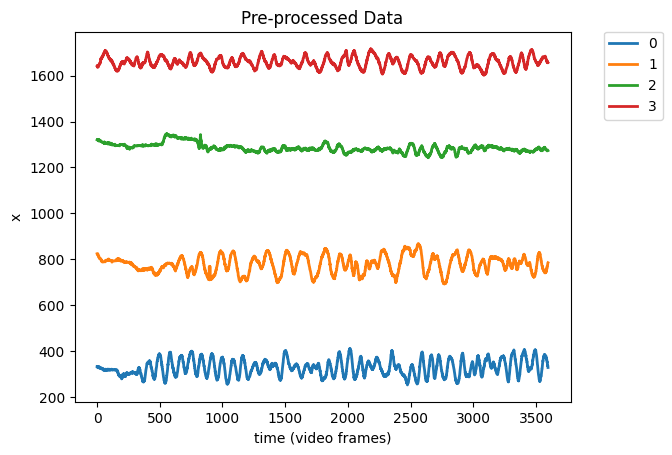

In [26]:
# Inspect pre-processed data:

sel_axis = 'x' # <---

#t_range = [0,fps*16] # <--- time range to plot in frames (fps*seconds = frames)
t_range = [0,data_red_df.image_id.max()] # <--- time range to plot in frames (fps*seconds = frames)

names_cols = [ f'{n}_{sel_axis}' for n in range(n_ppl)]
legend = []
for nc in names_cols:
    data_rar_df[nc].plot(linewidth=2)
    legend.append(nc.split('_')[0])
plt.legend(legend,loc='upper right', bbox_to_anchor=(1.2, 1.02))
plt.title('Pre-processed Data')
plt.xlabel('time (video frames)')
plt.ylabel(sel_axis);

In [27]:
# Write pre-processed data to a file:

if save_file:
    AP_results_fn_ne = AP_results_fn.split('.')[0]
    AP_pp_ffn = AP_results_path + '\\' + AP_results_fn_ne + '.parquet'
    data_rar_df.to_parquet(AP_pp_ffn)